In [424]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [837]:
import pandas as pd
import numpy as np
import io
import networkx as nx
from math import prod

from io import StringIO
from itertools import product, combinations, permutations
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
logger.setLevel(logging.INFO)

In [650]:
from analysis.community import Community, Hegemon, analyse_local_community, detect_local_communities
from analysis.network_analysis import get_networks, countCentrality, get_network_from_year_df, plotWithPyvis
from analysis.dataset_testing import pretest_dataset, test_triple_df

from data_handling import sipri, jme, interventions, deployments, fdi, trade, hitech, energy, refugee
from data_handling import migrant, tourism, humanun, visits, peacekeep, oda

from analysis.hegemony import get_hegemony_scores, get_hegemony_top, visualize_hegemony
from utils.utils import get_all_countries, get_empty_country_df, get_system_members, get_percent_df, test_df
from utils.countryconverter import convert_country_df

In [1207]:
YEAR_START=1985
YEAR_END=2022
SUBSYSTEM_WEIGHTS = {  # BY IHES 2022
    'human' : 1.79 / (1.79+2.4+3.2),
    'economy' : 2.4 / (1.79+2.4+3.2),
    'security' : 3.2 / (1.79+2.4+3.2)#,
#    'climate' : 2.64
}
rolling_window = 5

In [7]:
sm_dyads = get_system_members(YEAR_START, YEAR_END)
sm_set=set(sm_dyads['ego'])

## Coninuity conventions 
*(following Correlates of War Project. 2017. “State System Membership List, v2016.” Online, http://correlatesofwar.org)*

USSR (1985-1991) -> Russia

Socialist Federal Republic of Yugoslavia (1985-1992) -> Serbia

Federal Republic of Yugoslavia (1993-2003) -> Serbia

State Union of Serbia and Montenegro (2003-2006) -> Serbia

Czechoslovakia (1985-1992) -> No continuity

Federal Republic of Germany -> No continuity

East Germany -> No continuity

North Yemen -> No continuity

South Yemen -> No continuity

## Non-UN state inclusion
State of Palestine (UN observer state + good data availability)

## Data preprocessing

In [8]:
def show_top(df, x=20):
    return df.reset_index().groupby(['ego', 'year']).sum(numeric_only=True).sort_values('value', ascending=False).head(x)

In [9]:
def normalize(df):
    df_n = (df-df.mean())/df.std()
    df_n = df_n - df_n.min()
    return df_n

In [10]:
def to_mean(df):
    return df['value'] / df['value'].mean()

In [310]:
def remove_self_loops(df):
    temp = df.reset_index()
    temp = temp[temp['ego']!=temp['alter']]
    temp = temp.set_index(['year', 'alter', 'ego'])
    return temp

In [809]:
def merge_sphere(dfs, weights):
    sphere_triple = None
    for indicator in dfs:
        dfs[indicator]['value'] = to_mean(dfs[indicator])
    sphere_triple = sum(df_sphere * weight for df_sphere, weight in zip(dfs.values(), weights.values()))
    sphere_triple = remove_self_loops(sphere_triple)
    return sphere_triple

### International security

##### Arms Trade (SIPRI)

In [ ]:
sipri_df = sipri.load_sipri()
sipri_df, sipri_processed_df = sipri.preprocess_sipri(sipri_df, year_start=1985, rolling_window=5)
sipri_df.to_csv("../data/basic_preprocessed/arms.csv")
sipri_processed_df.to_csv("../data/preprocessed/arms.csv")

##### Interventions (Correlates of military interventions)

In [ ]:
interventions_df = interventions.load_interventions()
interventions_df, interventions_processed_df = interventions.preprocess_interventions(interventions_df, year_start=1985, neighbourhood_type=None)
interventions_df.to_csv("../data/basic_preprocessed/interventions.csv")
interventions_processed_df.to_csv("../data/preprocessed/interventions.csv")

##### Peacekeeping

In [ ]:
# Not using, for error checking only
peacekeep_df = peacekeep.load_peacekeep()
peacekeep_df, preprocess_peacekeep = peacekeep.preprocess_peacekeep(peacekeep_df, year_start=YEAR_START, year_end=YEAR_END)
peacekeep_df.to_csv("../data/basic_preprocessed/peacekeep.csv")
preprocess_peacekeep.to_csv("../data/preprocessed/peacekeep.csv")

#####  Joint military exercises

In [ ]:
# Not actually used
jme_df = jme.load_jme()
jme_df, jme_processed_df = jme.preprocess_jme(jme_df, year_start=YEAR_START, year_end=YEAR_END, gdp_threshold=0.75)
jme_df.to_csv("../data/basic_preprocessed/jme.csv")
jme_processed_df.to_csv("../data/preprocessed/jme.csv")

##### Military deployments

In [11]:
# from https://github.com/EmilStasevski/Military-Deployment/tree/main
# based on IISS Military Balance

In [ ]:
deployments_df = deployments.load_deployments(filter_un=True)
deployments_df, deployments_processed_df = deployments.preprocess_deployments(deployments_df, year_start=YEAR_START, logarithmic=True)
deployments_df.to_csv("../data/basic_preprocessed/deployments.csv")
deployments_processed_df.to_csv("../data/preprocessed/deployments.csv")

##### Merging

In [927]:
deployments_processed_df['value'] = (deployments_processed_df['value'] / deployments_processed_df['value'].mean())
sipri_processed_df['value'] = (sipri_processed_df['value'] / sipri_processed_df['value'].mean())
interventions_processed_df['value'] = (interventions_processed_df['value'] / interventions_processed_df['value'].mean())
jme_processed_df['value'] = (jme_processed_df['value'] / jme_processed_df['value'].mean())

In [928]:
security_triple = (
    interventions_processed_df * 0.13 + 
    sipri_processed_df * 0.12 + 
    deployments_processed_df * 0.145 #+ 
    #jme_processed_df * 0.13
)
security_triple.fillna(0,inplace=True)
security_triple = remove_self_loops(security_triple)

### Economy

##### FDI (UNCTAD + Investment_map + IMF)

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/fdi.py:22: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FDI_PATH, index_col='Unnamed: 0')
INFO:root:Loaded FDI data
INFO:root:Preprocessing fdi Depoyment Data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Bermuda, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier British Virgin Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Cayman Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country},

United Kingdom United Kingdom of Great Britain and Northern Ireland
Bermuda None
British Virgin Islands None
Liechtenstein Liechtenstein
Kuwait Kuwait
Palestine, State of State of Palestine
United States United States
Saint Kitts and Nevis Saint Kitts and Nevis
Bolivia, Plurinational State of Bolivia (Plurinational State of)
Spain Spain
Fiji Fiji
Nigeria Nigeria
Cayman Islands None
Gambia Gambia
Guyana Guyana
Kingdom of Eswatini Kingdom of Eswatini
Burkina Faso Burkina Faso
Sao Tome and Principe Sao Tome and Principe
Congo Congo
Area not elsewhere specified None
Andorra Andorra
Oceania not elsewhere specified None
Maldives Maldives
Democratic People's Republic of Korea Democratic People's Republic of Korea
Norway Norway
Wallis and Futuna Islands None
Jordan Jordan
Madagascar Madagascar
Philippines Philippines
Mayotte None
United Kingdom of Great Britain and Northern Ireland United Kingdom of Great Britain and Northern Ireland
Kyrgyzstan Kyrgyzstan
Guam None
Republic of North Macedonia 

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier British Virgin Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Bermuda, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Cayman Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Area not elsewhere specified, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home

United Kingdom United Kingdom of Great Britain and Northern Ireland
British Virgin Islands None
Bermuda None
Liechtenstein Liechtenstein
Kuwait Kuwait
Palestine, State of State of Palestine
United States United States
Saint Kitts and Nevis Saint Kitts and Nevis
Fiji Fiji
Spain Spain
Bolivia, Plurinational State of Bolivia (Plurinational State of)
Nigeria Nigeria
Cayman Islands None
Gambia Gambia
Guyana Guyana
Burkina Faso Burkina Faso
Kingdom of Eswatini Kingdom of Eswatini
Sao Tome and Principe Sao Tome and Principe
Congo Congo
Area not elsewhere specified None
Andorra Andorra
Oceania not elsewhere specified None
Maldives Maldives
Democratic People's Republic of Korea Democratic People's Republic of Korea
Norway Norway
Wallis and Futuna Islands None
Jordan Jordan
Madagascar Madagascar
Philippines Philippines
Mayotte None
United Kingdom of Great Britain and Northern Ireland United Kingdom of Great Britain and Northern Ireland
Guam None
Kyrgyzstan Kyrgyzstan
Republic of North Macedonia 

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/fdi.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_triple = df.groupby(["year", "Country", "Partner Country"]).sum()
INFO:root:Testing initiated
INFO:root:Missing 3(193/196 = (0.9846938775510204)) egos, 3(193/196 = 0.9846938775510204) alters, 23 years
INFO:root:Missing egos: {'San Marino', 'Czechoslovakia', 'German Democratic Republic'}
INFO:root:Missing great egos: set()
INFO:root:Missing alters: {'San Marino', 'Czechoslovakia', 'German Democratic Republic'}
INFO:root:Missing great alters: set()
INFO:root:Missing years: {1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008}
INFO:root:1311926 - 129734 = 1182192 lines missing (0.09888819

United Kingdom United Kingdom of Great Britain and Northern Ireland
Bermuda None
British Virgin Islands None
China, Taiwan Province of None
Kuwait Kuwait
United Kingdom including Channel Islands and Isle of Man None
Fiji Fiji
Saint Kitts and Nevis Saint Kitts and Nevis
United States United States
Spain Spain
South-eastern Asia None
LDCs: Asia None
Nigeria Nigeria
Cayman Islands None
Guyana Guyana
Burkina Faso Burkina Faso
LLDCs (Landlocked developing countries) None
Turkiye Türkiye
Sao Tome and Principe Sao Tome and Principe
SIDS: Pacific None
Africa None
Congo Congo
Developed economies: Asia None
Norway Norway
Asia None
Jordan Jordan
LDCs (Least developed countries) None
Madagascar Madagascar
Philippines Philippines
North Macedonia Republic of North Macedonia
Kyrgyzstan Kyrgyzstan
Tonga Tonga
Russian Federation Russian Federation
Ghana Ghana
Italy Italy
Mozambique Mozambique
Algeria Algeria
Israel Israel
LDCs: Africa None
European Union (2020 …) None
Belgium Belgium
Benin Benin
Centra

INFO:root:Done preprocessing FDI Data


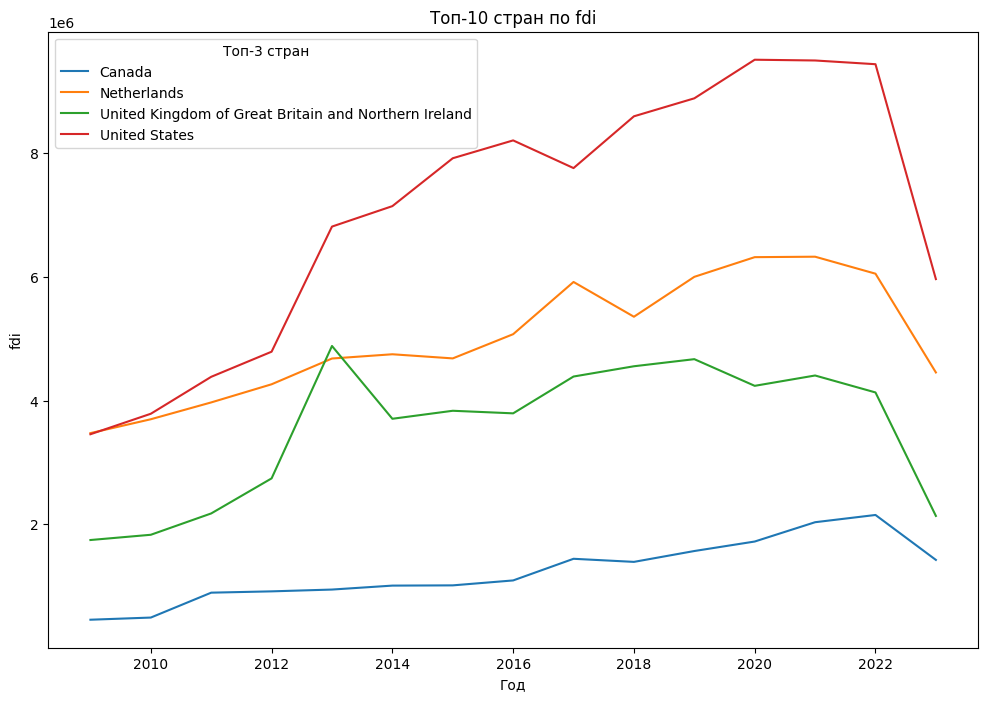

In [606]:
fdi_df = fdi.load_fdi(year_start=2009)  # Bad data before 2009
fdi_df, fdi_processed_df = fdi.preprocessed_fdi(fdi_df, year_start=YEAR_START, year_end=YEAR_END, rolling_window=5)
#fdi_df_historic_extended=fdi.load_historic_fdi(year_start=YEAR_START)
fdi_df.to_csv("../data/basic_preprocessed/fdi.csv")
fdi_processed_df.to_csv("../data/preprocessed/fdi.csv")
#fdi_df_historic_extended.to_csv("../data/preprocessed/fdi_historic.csv")

In [318]:
fdi_df = pd.read_csv("../data/basic_preprocessed/fdi.csv", index_col = 'Unnamed: 0')
fdi_processed_df = pd.read_csv("../data/preprocessed/fdi.csv").set_index(['ego', 'alter', 'year'])
#fdi_df_historic_extended = pd.read_csv("../data/preprocessed/fdi_historic.csv").set_index(['ego', 'year'])

/tmp/ipykernel_361163/621468177.py:1: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  fdi_df = pd.read_csv("../data/basic_preprocessed/fdi.csv", index_col = 'Unnamed: 0')


#### Trade

INFO:root:reading 1985_1988_TradeData_3_18_2025_7_35_8.csv
INFO:root:reading 1989_1994_TradeData_3_18_2025_7_35_8.csv
INFO:root:reading 1995_2000.csv
INFO:root:reading 2001_2004.csv
INFO:root:reading 2005_2008.csv
INFO:root:reading 2009_2012.csv
INFO:root:reading 2013_2016.csv
INFO:root:reading 2017_2020.csv
INFO:root:reading 2021_2022.csv
INFO:root:reading 1985_1994_USSR_RUssia_mirror.csv
INFO:root:reading 2001_2012_SaudiArabia_Venezuela_Libya_mirror.csv
INFO:root:reading 2013_2022_SaudiArabia_Venezuela_Libya_mirror.csv
INFO:root:reading 1989_1994_Andorra_mirror.csv
INFO:root:reading 1985_1988_Andorra_mirror.csv
INFO:root:Removing 47 rows from ['VEN' 'LBY' 'SAU' 'S19' 'ISR' 'PAK' 'CHN'], years [2006 2008 2005 2004 2013 2012 2001 2011 2014 2002 2007 2010 2003 2021
 2022 2019 2018 2009 2020 2015 2017 2016 1999 1995 1996 1997 1998 2000
 1988 1986 1992 1991 1989 1987]
INFO:root:Preprocessing trade data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserW

VNM Viet Nam
GRC Greece
BTN Bhutan
CMR Cameroon
GBR United Kingdom of Great Britain and Northern Ireland
PNG Papua New Guinea
LBR Liberia
MKD Republic of North Macedonia
CZE Czechia
TON Tonga
TUR Türkiye
COL Colombia
SUR Suriname
RWA Rwanda
TZA United Republic of Tanzania
GUY Guyana
GAB Gabon
BLZ Belize
ABW None
TCA None
THA Thailand
MDA Republic of Moldova
HUN Hungary
S19 None
MMR Myanmar
DNK Denmark
ERI Eritrea
BEL Belgium
ZMB Zambia
REU None
ZA1 None
JAM Jamaica
KWT Kuwait
MNE Montenegro
MTQ None
MNG Mongolia
RUS Russian Federation
FIN Finland
MYS Malaysia
ARG Argentina
ARM Armenia
MAR Morocco
BGR Bulgaria
EST Estonia
BIH Bosnia and Herzegovina
MOZ Mozambique
MWI Malawi
USA United States
TGO Togo
ATG Antigua and Barbuda
ESP Spain
PHL Philippines
AFG Afghanistan
NIC Nicaragua
NIU None
NER Niger
NPL Nepal
YUG Serbia
CPV Cabo Verde
DMA Dominica
BLR Belarus
KIR Kiribati
SWE Sweden
DJI Djibouti
AUT Austria
SVK Slovakia
VUT Vanuatu
ISR Israel
URY Uruguay
MUS Mauritius
COD Democratic Repub

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier F49, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier A79, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier CXR, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier ABW, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/country

VNM Viet Nam
GRC Greece
BTN Bhutan
CMR Cameroon
SSD South Sudan
F49 None
GBR United Kingdom of Great Britain and Northern Ireland
A79 None
PNG Papua New Guinea
LBR Liberia
MKD Republic of North Macedonia
CXR None
CZE Czechia
TON Tonga
TUR Türkiye
COL Colombia
SUR Suriname
RWA Rwanda
TZA United Republic of Tanzania
ABW None
GUY Guyana
X2  None
BLZ Belize
GAB Gabon
THA Thailand
MDA Republic of Moldova
HUN Hungary
TCA None
S19 None
MMR Myanmar
DNK Denmark
WLF None
MNP None
SGS None
ERI Eritrea
VGB None
BEL Belgium
ZMB Zambia
REU None
ZA1 None
JAM Jamaica
KWT Kuwait
MNE Montenegro
MTQ None
MNG Mongolia
RUS Russian Federation
FIN Finland
MYS Malaysia
NRU Nauru
ATA None
ARG Argentina
ARM Armenia
MAR Morocco
BGR Bulgaria
EST Estonia
W00 None
MHL Marshall Islands
MOZ Mozambique
USA United States
TGO Togo
GNQ Equatorial Guinea
XX  None
BIH Bosnia and Herzegovina
MWI Malawi
CCK None
SXM None
E29 None
ATG Antigua and Barbuda
ESP Spain
PHL Philippines
VAT None
AFG Afghanistan
NIC Nicaragua
NIU Non

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/trade.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_triple = df.groupby([YEAR_LABEL, EGO_LABEL, ALTER_LABEL]).sum()
INFO:root:Testing initiated
INFO:root:Missing 12(184/196 = (0.9387755102040817)) egos, 3(193/196 = 0.9846938775510204) alters, -2 years
INFO:root:Missing egos: {'Nauru', 'Liechtenstein', 'Monaco', 'German Democratic Republic', 'Equatorial Guinea', "Democratic People's Republic of Korea", 'Czechoslovakia', 'South Sudan', 'San Marino', 'Somalia', 'Chad', 'Marshall Islands'}
INFO:root:Missing great egos: set()
INFO:root:Missing alters: {'Czechoslovakia', 'Liechtenstein', 'German Democratic Republic'}
INFO:root:Missing great alters: set()
INFO:root:Missing years: set()
INFO:root:1314546 - 617120 = 697426 lines mis

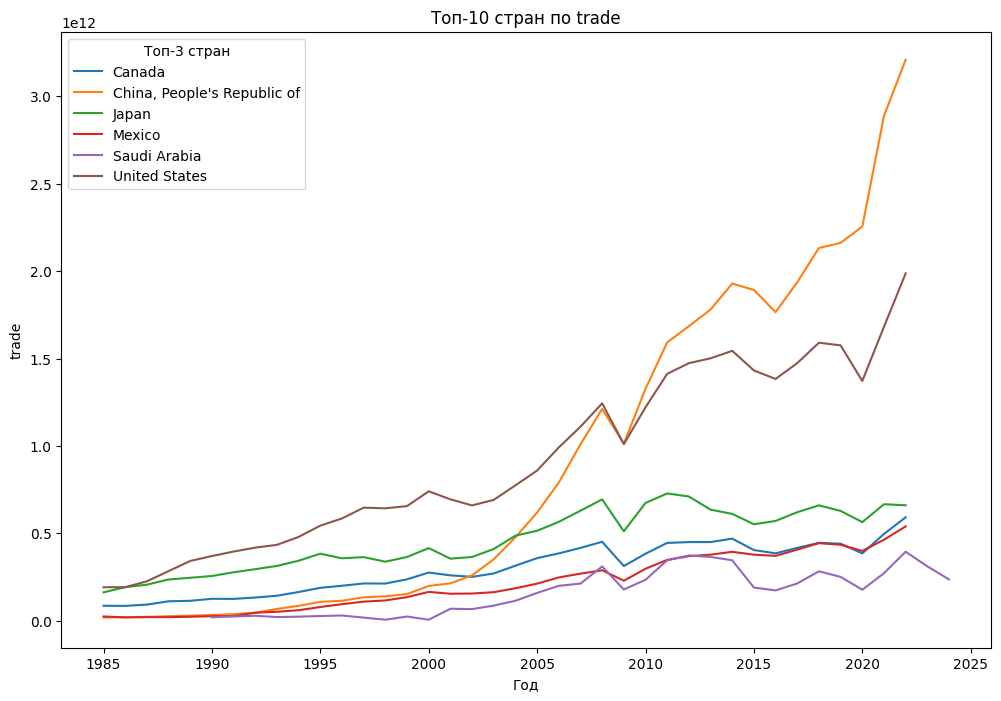

In [1059]:
trade_df = trade.load_trade()
trade_df, trade_processed_df = trade.preprocess_trade(trade_df, year_start=YEAR_START, rolling_window=5)
trade_df.to_csv("../data/basic_preprocessed/trade.csv")
trade_processed_df.to_csv("../data/preprocessed/trade.csv")

#### Hi-tech trade

In [ ]:
hitech_df = hitech.load_hitech()
hitech_df, hitech_processed_df = hitech.preprocess_hitech(trade_df, year_start=YEAR_START, rolling_window=5)
hitech_df.to_csv("../data/basic_preprocessed/hitech.csv")
hitech_processed_df.to_csv("../data/preprocessed/hitech.csv")

#### Energy trade

In [ ]:
energy_df = energy.load_energy()
energy_df, energy_processed_df = energy.preprocess_energy(energy_df, year_start=YEAR_START, rolling_window=5, normalize=True)
energy_df.to_csv("../data/basic_preprocessed/energy.csv")
energy_processed_df.to_csv("../data/preprocessed/energy.csv")

#### Merging

In [1060]:
economy_dfs = {
    'fdi':fdi_processed_df,
    'trade':trade_processed_df,
    'hitech':hitech_processed_df,
    'energy':energy_processed_df
}
ECONOMY_WEIGHTS = {
    'fdi':0.5,
    'trade':0.5,
    'hitech':0.2,
    'energy':0.3
}
economy_triple = merge_sphere(economy_dfs, ECONOMY_WEIGHTS)

### Humanitarian Data

#### Refugee

INFO:root:Preprocessing refugee data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Bermuda, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Cayman Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Martinique, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Niue, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/hom

Bermuda None
Kuwait Kuwait
Liechtenstein Liechtenstein
Fiji Fiji
Saint Kitts and Nevis Saint Kitts and Nevis
Spain Spain
Nigeria Nigeria
Cayman Islands None
Gambia Gambia
Guyana Guyana
Burkina Faso Burkina Faso
Sao Tome and Principe Sao Tome and Principe
United Rep. of Tanzania United Republic of Tanzania
Congo Congo
Andorra Andorra
Maldives Maldives
Norway Norway
Jordan Jordan
Rep. of Korea Republic of Korea
Madagascar Madagascar
Philippines Philippines
Martinique None
Central African Rep. Central African Republic
North Macedonia Republic of North Macedonia
United Kingdom of Great Britain and Northern Ireland United Kingdom of Great Britain and Northern Ireland
Kyrgyzstan Kyrgyzstan
Tonga Tonga
Nauru Nauru
Russian Federation Russian Federation
Bhutan Bhutan
Ghana Ghana
United States of America United States
Italy Italy
Mozambique Mozambique
Algeria Algeria
Israel Israel
Belgium Belgium
Benin Benin
Saint Lucia Saint Lucia
Timor-Leste Timor-Leste
Austria Austria
Antigua and Barbuda Anti

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Cayman Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Montserrat, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Anguilla, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Unknown , replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/p

Kuwait Kuwait
Liechtenstein Liechtenstein
Fiji Fiji
Saint Kitts and Nevis Saint Kitts and Nevis
Spain Spain
Nigeria Nigeria
Cayman Islands None
Gambia Gambia
Guyana Guyana
Burkina Faso Burkina Faso
United Rep. of Tanzania United Republic of Tanzania
Congo Congo
Norway Norway
Jordan Jordan
Rep. of Korea Republic of Korea
Madagascar Madagascar
Philippines Philippines
Central African Rep. Central African Republic
United Kingdom of Great Britain and Northern Ireland United Kingdom of Great Britain and Northern Ireland
North Macedonia Republic of North Macedonia
Kyrgyzstan Kyrgyzstan
Nauru Nauru
Russian Federation Russian Federation
Ghana Ghana
United States of America United States
Italy Italy
Mozambique Mozambique
Algeria Algeria
Israel Israel
Belgium Belgium
Benin Benin
Montserrat None
Saint Lucia Saint Lucia
Timor-Leste Timor-Leste
Austria Austria
Antigua and Barbuda Antigua and Barbuda
Türkiye Türkiye
Uganda Uganda
Monaco Monaco
Netherlands (Kingdom of the) Netherlands
South Sudan Sout

INFO:root:Testing initiated
INFO:root:Missing 21(175/196 = (0.8928571428571429)) egos, 3(193/196 = 0.9846938775510204) alters, 0 years
INFO:root:Missing egos: {'Serbia', 'Myanmar', 'Sao Tome and Principe', 'Cabo Verde', 'Andorra', 'German Democratic Republic', 'Saint Vincent and the Grenadines', 'Maldives', 'State of Palestine', "Democratic People's Republic of Korea", 'San Marino', 'Brunei Darussalam', 'Tonga', 'Bhutan', 'Equatorial Guinea', 'Tuvalu', 'Czechoslovakia', 'Seychelles', 'Kiribati', 'Dominica', 'Marshall Islands'}
INFO:root:Missing great egos: set()
INFO:root:Missing alters: {'Czechoslovakia', 'Serbia', 'German Democratic Republic'}
INFO:root:Missing great alters: set()
INFO:root:Missing years: set()
INFO:root:1311926 - 108769 = 1203157 lines missing (0.08290787742601335)
INFO:root:                                   0
Source name                  refugee
Missing egos                      21
Missing great egos                 0
Missing alters                     3
Missing g

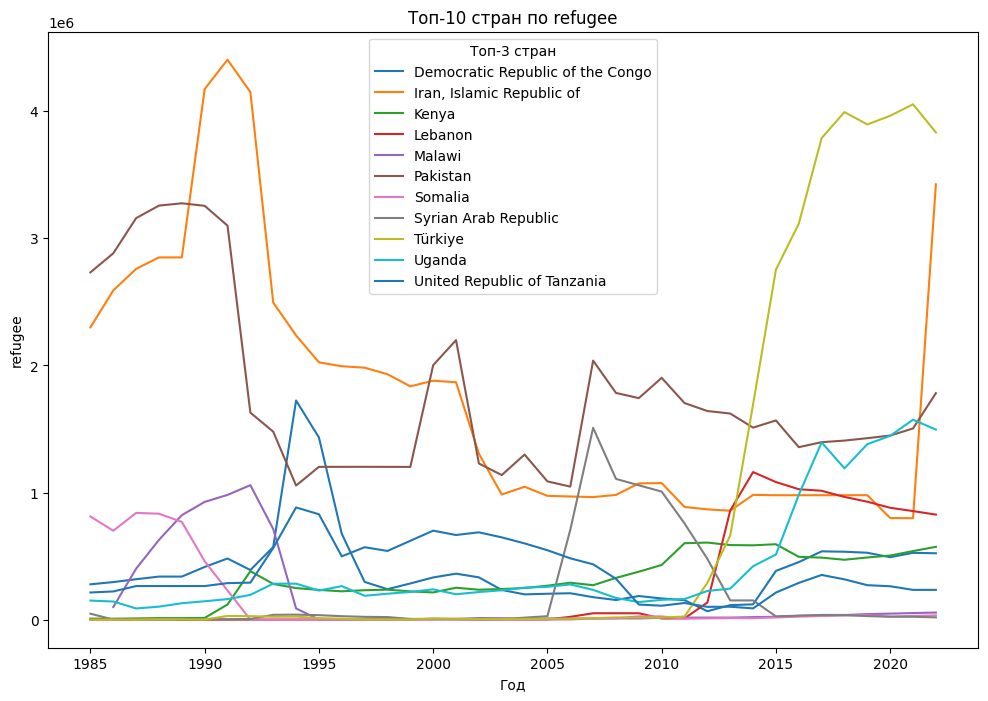

In [666]:
refugee_df = refugee.load_refugee()
refugee_df, refugee_processed_df = refugee.preprocess_refugee(refugee_df, year_start=YEAR_START, rolling_window=1, logarithmic=True)
refugee_df.to_csv("../data/basic_preprocessed/refugee.csv")
refugee_processed_df.to_csv("../data/preprocessed/refugee.csv")

#### Migrant

INFO:root:Preprocessing migrant data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 922, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 925, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 905, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 254, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Рабо

800 Uganda
426 Lesotho
922 None
925 None
760 Syrian Arab Republic
120 Cameroon
706 Somalia
616 Poland
233 Estonia
300 Greece
591 Panama
905 None
24 Angola
798 Tuvalu
498 Republic of Moldova
170 Colombia
203 Czechia
250 France
440 Lithuania
152 Chile
887 Yemen
76 Brazil
854 Burkina Faso
254 None
927 None
740 Suriname
438 Liechtenstein
48 Bahrain
1831 None
882 Samoa
578 Norway
784 United Arab Emirates
894 Zambia
348 Hungary
690 Seychelles
324 Guinea
31 Azerbaijan
2003 None
654 None
704 Viet Nam
923 None
222 El Salvador
624 Guinea-Bissau
196 Cyprus
504 Morocco
1859 None
454 Malawi
178 Congo
830 None
28 Antigua and Barbuda
659 Saint Kitts and Nevis
678 Sao Tome and Principe
508 Mozambique
422 Lebanon
756 Switzerland
558 Nicaragua
212 Dominica
16 None
484 Mexico
50 Bangladesh
8 Albania
724 Spain
234 None
909 None
931 None
496 Mongolia
450 Madagascar
104 Myanmar
934 None
214 Dominican Republic
540 None
528 Netherlands
1834 None
328 Guyana
520 Nauru
818 Egypt
360 Indonesia
116 Cambodia
908 No

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 922, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 925, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 905, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier 254, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/country

800 Uganda
426 Lesotho
922 None
925 None
760 Syrian Arab Republic
120 Cameroon
706 Somalia
616 Poland
233 Estonia
300 Greece
591 Panama
905 None
24 Angola
798 Tuvalu
498 Republic of Moldova
170 Colombia
203 Czechia
250 France
440 Lithuania
152 Chile
887 Yemen
76 Brazil
854 Burkina Faso
254 None
927 None
740 Suriname
438 Liechtenstein
48 Bahrain
1831 None
882 Samoa
578 Norway
784 United Arab Emirates
894 Zambia
348 Hungary
690 Seychelles
324 Guinea
31 Azerbaijan
654 None
704 Viet Nam
923 None
222 El Salvador
624 Guinea-Bissau
196 Cyprus
504 Morocco
1859 None
454 Malawi
178 Congo
830 None
28 Antigua and Barbuda
659 Saint Kitts and Nevis
678 Sao Tome and Principe
508 Mozambique
422 Lebanon
756 Switzerland
558 Nicaragua
212 Dominica
16 None
484 Mexico
50 Bangladesh
8 Albania
724 Spain
234 None
909 None
931 None
496 Mongolia
450 Madagascar
104 Myanmar
934 None
214 Dominican Republic
540 None
528 Netherlands
1834 None
328 Guyana
520 Nauru
818 Egypt
360 Indonesia
116 Cambodia
908 None
642 Rom

INFO:root:Testing initiated
INFO:root:Missing 3(193/196 = (0.9846938775510204)) egos, 3(193/196 = 0.9846938775510204) alters, 31 years
INFO:root:Missing egos: {'Czechoslovakia', 'State of Palestine', 'German Democratic Republic'}
INFO:root:Missing great egos: set()
INFO:root:Missing alters: {'Czechoslovakia', 'State of Palestine', 'German Democratic Republic'}
INFO:root:Missing great alters: set()
INFO:root:Missing years: {1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2021, 2022}
INFO:root:1314546 - 53500 = 1261046 lines missing (0.04069846167422061)
INFO:root:                                   0
Source name                  migrant
Missing egos                       3
Missing great egos                 0
Missing alters                     3
Missing great alters               0
Missing years                     31
Missing yearly dyads           87606
Egos perc

                             value
year ego         alter            
1985 Afghanistan Albania  0.000000
1986 Afghanistan Albania  0.000000
1987 Afghanistan Albania  0.000000
1988 Afghanistan Albania  0.000000
1989 Afghanistan Albania  0.000000
...                            ...
2018 Zimbabwe    Zambia   0.896968
2019 Zimbabwe    Zambia   0.896968
2020 Zimbabwe    Zambia   0.900190
2021 Zimbabwe    Zambia   0.900190
2022 Zimbabwe    Zambia   0.900190

[1448864 rows x 1 columns]
Empty DataFrame
Columns: []
Index: [(1985, Fiji, Kuwait), (1985, Saint Kitts and Nevis, Kuwait), (1985, United States, Kuwait), (1985, Spain, Kuwait), (1985, Nigeria, Kuwait), (1985, Gambia, Kuwait), (1985, Guyana, Kuwait), (1985, Burkina Faso, Kuwait), (1985, Kingdom of Eswatini, Kuwait), (1985, Sao Tome and Principe, Kuwait), (1985, Congo, Kuwait), (1985, Andorra, Kuwait), (1985, Maldives, Kuwait), (1985, Democratic People's Republic of Korea, Kuwait), (1985, Norway, Kuwait), (1985, Jordan, Kuwait), (1985, Mad

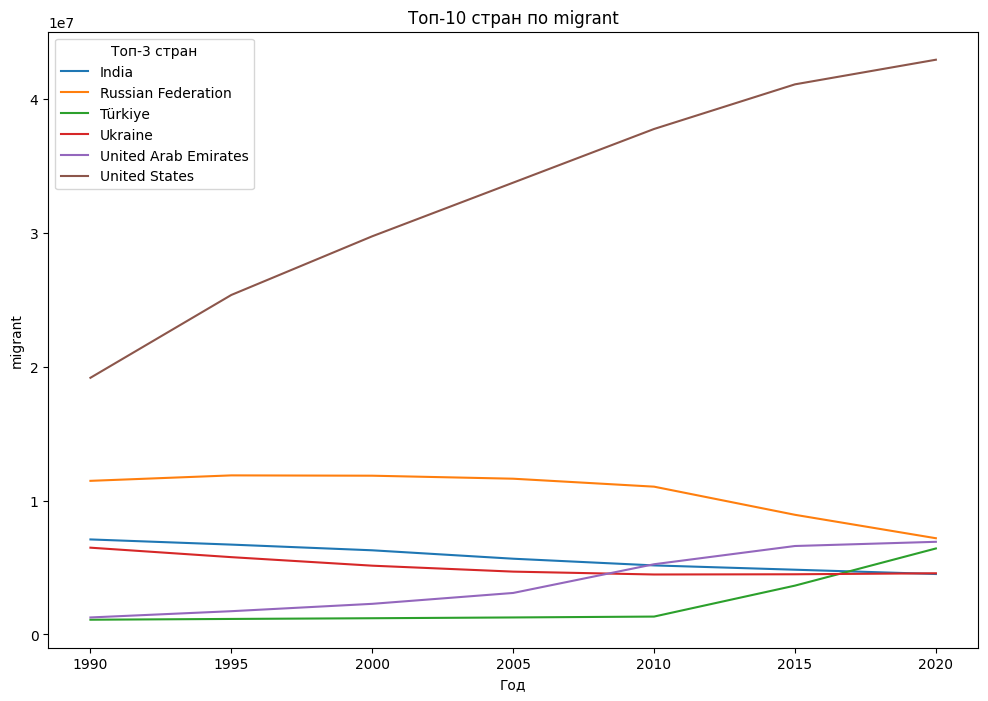

In [1172]:
migrant_df = migrant.load_migrant(YEAR_START, YEAR_END)
migrant_df, migrant_processed_df = migrant.preprocess_migrant(migrant_df, year_start=YEAR_START, rolling_window=5, interpolate=True, logarithmic=True)
migrant_df.to_csv("../data/basic_preprocessed/migrant.csv")
migrant_processed_df.to_csv("../data/preprocessed/migrant.csv")

### Tourism

In [ ]:
# Non-vector, unused

### ODA/Foreign Aid

INFO:root:Reading OECD ODA Data (DAC2)
INFO:root:Reading China ODA-like Data (Aiddata)
INFO:root:Reading China historic foreign aid data (CIA)
INFO:root:Reading Russia ODA data
INFO:root:Reading India ODA data from India development finance dataset
INFO:root:Preprocessing oda data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier British Virgin Islands, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier All multilateral recipients, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier C�te d'Ivoire, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}

British Virgin Islands None
Kuwait Kuwait
Fiji Fiji
Saint Kitts and Nevis Saint Kitts and Nevis
Micronesia Micronesia (Federated States of)
All multilateral recipients None
C�te d'Ivoire None
Gambia Gambia
Burkina Faso Burkina Faso
Korea Republic of Korea
Sao Tome and Principe Sao Tome and Principe
Micronesia unspecified None
Oceania unspecified None
Ghana Ghana
Czech Republic Czechia
Europe unspecified None
African Development Fund [AfDF] None
Lao People's Democratic Republic Lao People's Democratic Republic
Laos Lao People's Democratic Republic
Moldova Republic of Moldova
Antigua and Barbuda Antigua and Barbuda
IDA-MDRI None
Burkina Burkina Faso
Dominica Dominica
ACP None
Lesotho Lesotho
Cote d'Ivoire Côte d'Ivoire
China (People’s Republic of) China, People's Republic of
Turkmenistan Turkmenistan
Other Regional Banks None
Guinea-Bissau Guinea-Bissau
Republic of Congo None
Central Asia unspecified None
Zimbabwe Zimbabwe
Indonesia Indonesia
Lower-middle income countries (World Bank) No

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Official donors, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Central American Bank for Economic Integration [CABEI], replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier William and Flora Hewlett Foundation, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier Private Donors, replacing with None
  if warning: warnings.warn(f"Unknown identifier {co

Official donors None
United Kingdom United Kingdom of Great Britain and Northern Ireland
Central American Bank for Economic Integration [CABEI] None
Kuwait Kuwait
Liechtenstein Liechtenstein
United States United States
Spain Spain
William and Flora Hewlett Foundation None
Private Donors None
World Health Organisation [WHO] None
LEGO Foundation None
Inter-American Development Bank None
Global Green Growth Institute [GGGI] None
Korea Republic of Korea
UNRWA None
Leona M. and Harry B. Helmsley Charitable Trust None
Chinese Taipei None
Norway Norway
Gates Foundation None
Regional Development Banks None
International Development Association [IDA] None
MetLife Foundation None
Arcus Foundation None
Islamic Development Bank [IsDB] None
African Development Bank None
WTO - International Trade Centre [ITC] None
Italy Italy
McKnight Foundation None
United Nations Conference on Trade and Development [UNCTAD] None
Caribbean Development Bank [CarDB] None
Israel Israel
Private Infrastructure Developme

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/oda.py:116: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_triple = df.groupby([YEAR_LABEL, ALTER_LABEL, EGO_LABEL]).sum()
INFO:root:Testing initiated
INFO:root:Missing 145(51/196 = (0.2602040816326531)) egos, 39(157/196 = 0.8010204081632653) alters, 0 years
INFO:root:Missing egos: {'Fiji', 'Saint Kitts and Nevis', 'Nigeria', 'Gambia', 'Guyana', 'Burkina Faso', 'Kingdom of Eswatini', 'Sao Tome and Principe', 'Congo', 'Andorra', 'Maldives', "Democratic People's Republic of Korea", 'Jordan', 'Madagascar', 'Philippines', 'Kyrgyzstan', 'Republic of North Macedonia', 'Nauru', 'Tonga', 'Bhutan', 'Ghana', 'Mozambique', 'Algeria', 'Benin', 'Central African Republic', "Lao People's Democratic Republic", 'Saint Lucia', 'Antigua and Barbuda',

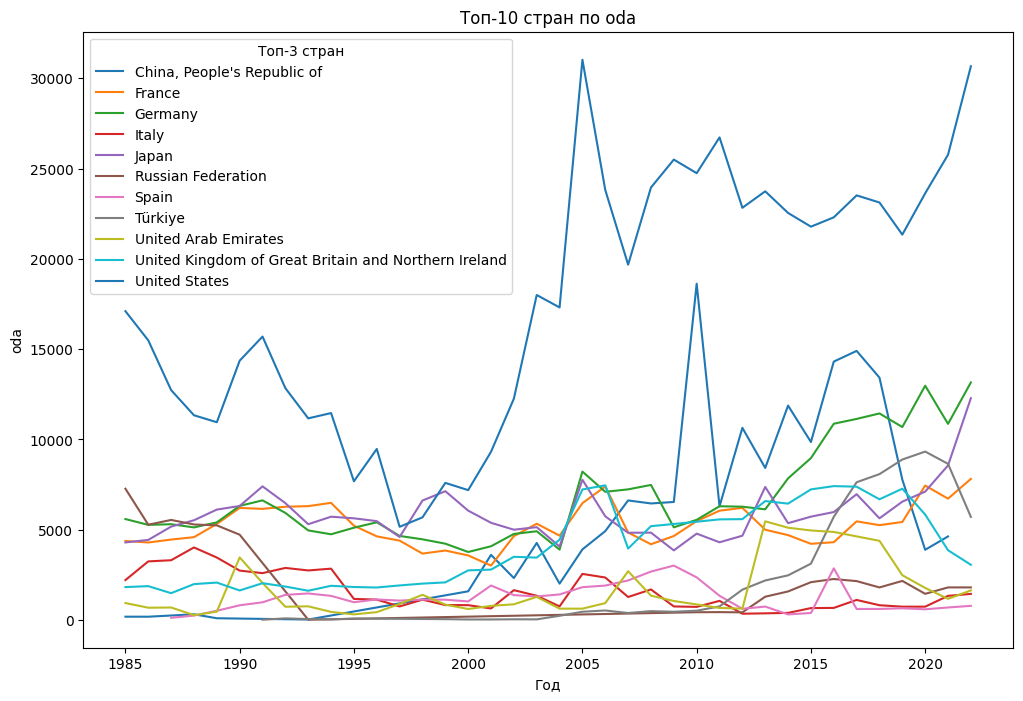

In [651]:
oda_df = oda.load_oda()
oda_df, oda_processed_df = oda.preprocess_oda(oda_df, year_start=YEAR_START, year_end=YEAR_END, rolling_window=7)
oda_df.to_csv("../data/basic_preprocessed/oda.csv")
oda_processed_df.to_csv("../data/preprocessed/oda.csv")

### UN Resolutions

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/humanun.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  humanun_df_in = pd.read_csv(humanun_PATH, index_col = 'Unnamed: 0')
INFO:root:Preprocessing humanun data


El Salvador El Salvador
Lebanon Lebanon
Burundi Burundi
Mali Mali
Yemen Yemen
Myanmar Myanmar
Palestinian State of Palestine
Russia Russian Federation
Guinea Guinea
Nigeria Nigeria
Angola Angola
Afghanistan Afghanistan
Chad Chad
Turkmenistan Turkmenistan
Iran Iran, Islamic Republic of
Nepal Nepal
Liberia Liberia
Nicaragua Nicaragua
Marshall Islands Marshall Islands
Togo Togo
Sierra Leone Sierra Leone
Venezuela Venezuela (Bolivarian Republic of)
Zaire Democratic Republic of the Congo
Democratic People's Republic of Korea Democratic People's Republic of Korea
Cambodia Cambodia
South Africa South Africa
Ethiopia Ethiopia
Yugoslavia Serbia
Papua New Guinea Papua New Guinea
Haiti Haiti
Libya Libya
Philippines Philippines
Belarus Belarus
Ukraine Ukraine
Kyrgyzstan Kyrgyzstan
East Timor Timor-Leste
Russian Federation Russian Federation
Equatorial Guinea Equatorial Guinea
Bosnia and Herzegovina Bosnia and Herzegovina
Guatemala Guatemala
Israel Israel
Rwanda Rwanda
Republic of Korea Republic of

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/humanun.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_triple = df.groupby([YEAR_LABEL, ALTER_LABEL, EGO_LABEL]).sum()
INFO:root:Testing initiated
INFO:root:Missing 26(170/196 = (0.8673469387755102)) egos, 138(58/196 = 0.29591836734693877) alters, 7 years
INFO:root:Missing egos: {'Bahamas', 'Tajikistan', 'Turkmenistan', 'Suriname', 'Sao Tome and Principe', 'German Democratic Republic', 'Saint Vincent and the Grenadines', 'Cambodia', 'Kazakhstan', 'Tonga', 'Belize', 'Bhutan', 'Tuvalu', 'Czechoslovakia', 'Seychelles', "Lao People's Democratic Republic", 'Saint Lucia', 'Grenada', 'Timor-Leste', 'Antigua and Barbuda', 'Kiribati', 'Eritrea', 'Mongolia', 'Dominica', 'Papua New Guinea', 'Comoros'}
INFO:root:Missing great egos: set(

KeyError: 'year'

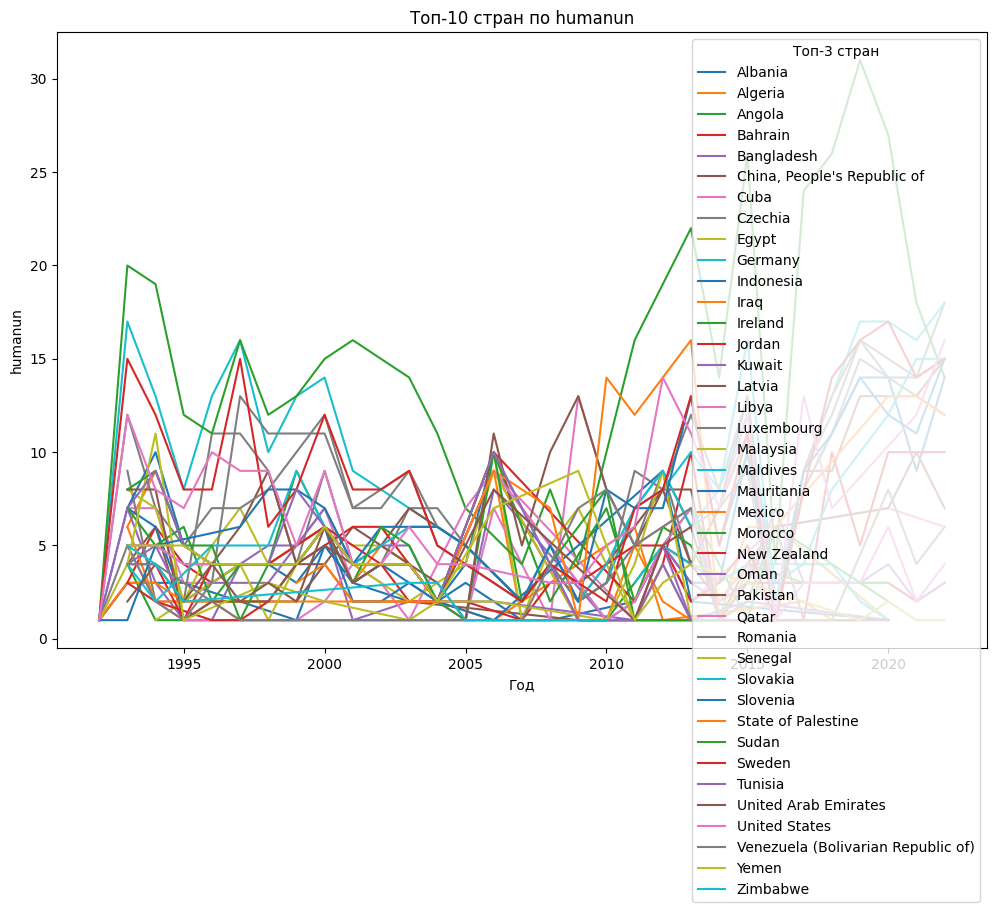

In [1014]:
humanun_df = humanun.load_humanun()
humanun_df, humanun_processed_df = humanun.preprocess_humanun(humanun_df, year_start=YEAR_START, year_end=YEAR_END, rolling_window=5, normalize=True, extrapolate=True)
humanun_df.to_csv("../data/basic_preprocessed/humanun.csv")
humanun_processed_df.to_csv("../data/preprocessed/humanun.csv")

#### Humanitarian conjoined

In [1174]:
migrant_processed_df['value'] = to_mean(migrant_processed_df)
refugee_processed_df['value'] = to_mean(refugee_processed_df)
humanun_processed_df['value'] = to_mean(humanun_processed_df)
oda_processed_df['value'] = to_mean(oda_processed_df)

In [1176]:
human_intermediate = (
    migrant_processed_df.fillna(0) * 0.16 + 
    refugee_processed_df.fillna(0) * 0.17  + 
    humanun_processed_df.fillna(0) * 0.155 +
    oda_processed_df.fillna(0) * 0.198# + tourism_inferred.fillna(0) * 0.14
                     )
human_intermediate = remove_self_loops(human_intermediate)

## Overall (Politics)

#### Diplomatic visits

INFO:root:Loaded Visits COLT Database
INFO:root:Preprocessing visits data
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier XLX, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier YAR, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier XAX, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier ESH, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_m

BEL Belgium
FSM Micronesia (Federated States of)
ZMB Zambia
URY Uruguay
RWA Rwanda
KGZ Kyrgyzstan
WSM Samoa
HUN Hungary
SGP Singapore
NGA Nigeria
ZWE Zimbabwe
VEN Venezuela (Bolivarian Republic of)
VUT Vanuatu
CIV Côte d'Ivoire
IRL Ireland
HND Honduras
LCA Saint Lucia
SYR Syrian Arab Republic
PSE State of Palestine
GNB Guinea-Bissau
GUY Guyana
GHA Ghana
SMR San Marino
XLX None
YAR None
SYC Seychelles
MYS Malaysia
MHL Marshall Islands
IRN Iran, Islamic Republic of
ARM Armenia
DZA Algeria
JAM Jamaica
SWE Sweden
MUS Mauritius
DOM Dominican Republic
TUV Tuvalu
BIH Bosnia and Herzegovina
FRA France
AZE Azerbaijan
BDI Burundi
SDN Sudan
SVK Slovakia
KIR Kiribati
XAX None
USA United States
HTI Haiti
SAU Saudi Arabia
DNK Denmark
BLR Belarus
MMR Myanmar
NZL New Zealand
DEU Germany
NLD Netherlands
UGA Uganda
ESH None
BTN Bhutan
SLB Solomon Islands
AUS Australia
QAT Qatar
SWZ Kingdom of Eswatini
KHM Cambodia
XNC None
GAB Gabon
AND Andorra
BGD Bangladesh
NOR Norway
FRG None
XKX None
NIC Nicaragua
G

/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier XAN, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier XEC, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier XIB, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/countryconverter.py:101: UserWarning: Unknown identifier FRG, replacing with None
  if warning: warnings.warn(f"Unknown identifier {country}, replacing with {replace_missing}")
/home/alex-server/Sync/Работа/Code/phd_thesis/code/utils/country

BEL Belgium
FSM Micronesia (Federated States of)
ZMB Zambia
URY Uruguay
RWA Rwanda
KGZ Kyrgyzstan
WSM Samoa
HUN Hungary
SGP Singapore
NGA Nigeria
VEN Venezuela (Bolivarian Republic of)
VUT Vanuatu
ZWE Zimbabwe
CIV Côte d'Ivoire
IRL Ireland
HND Honduras
LCA Saint Lucia
UZB Uzbekistan
SYR Syrian Arab Republic
PSE State of Palestine
GNB Guinea-Bissau
GUY Guyana
GHA Ghana
SMR San Marino
SYC Seychelles
MYS Malaysia
MHL Marshall Islands
ARM Armenia
DZA Algeria
JAM Jamaica
PLW Palau
MUS Mauritius
SWE Sweden
DOM Dominican Republic
XAN None
TUV Tuvalu
BIH Bosnia and Herzegovina
FRA France
XEC None
AZE Azerbaijan
BDI Burundi
SVK Slovakia
SDN Sudan
KIR Kiribati
USA United States
HTI Haiti
SAU Saudi Arabia
DNK Denmark
BLR Belarus
MMR Myanmar
NZL New Zealand
DEU Germany
NLD Netherlands
UGA Uganda
BTN Bhutan
SLB Solomon Islands
AUS Australia
QAT Qatar
KHM Cambodia
AND Andorra
SWZ Kingdom of Eswatini
GAB Gabon
XIB None
BGD Bangladesh
NOR Norway
FRG None
XKX None
XMF None
NIC Nicaragua
MlI Mali
GNQ Eq

/home/alex-server/Sync/Работа/Code/phd_thesis/code/data_handling/visits.py:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_triple = df.groupby([YEAR_LABEL, EGO_LABEL, ALTER_LABEL]).sum()
INFO:root:Testing initiated
INFO:root:Missing 2(194/196 = (0.9897959183673469)) egos, 3(193/196 = 0.9846938775510204) alters, 3 years
INFO:root:Missing egos: {'German Democratic Republic', 'Czechoslovakia'}
INFO:root:Missing great egos: set()
INFO:root:Missing alters: {'German Democratic Republic', 'Czechoslovakia', 'Iran, Islamic Republic of'}
INFO:root:Missing great alters: set()
INFO:root:Missing years: {1985, 1986, 1987, 1988, 1989}
INFO:root:1311926 - 53989 = 1257937 lines missing (0.04115247353890387)
INFO:root:                                   0
Source name                   visits
Missing egos       

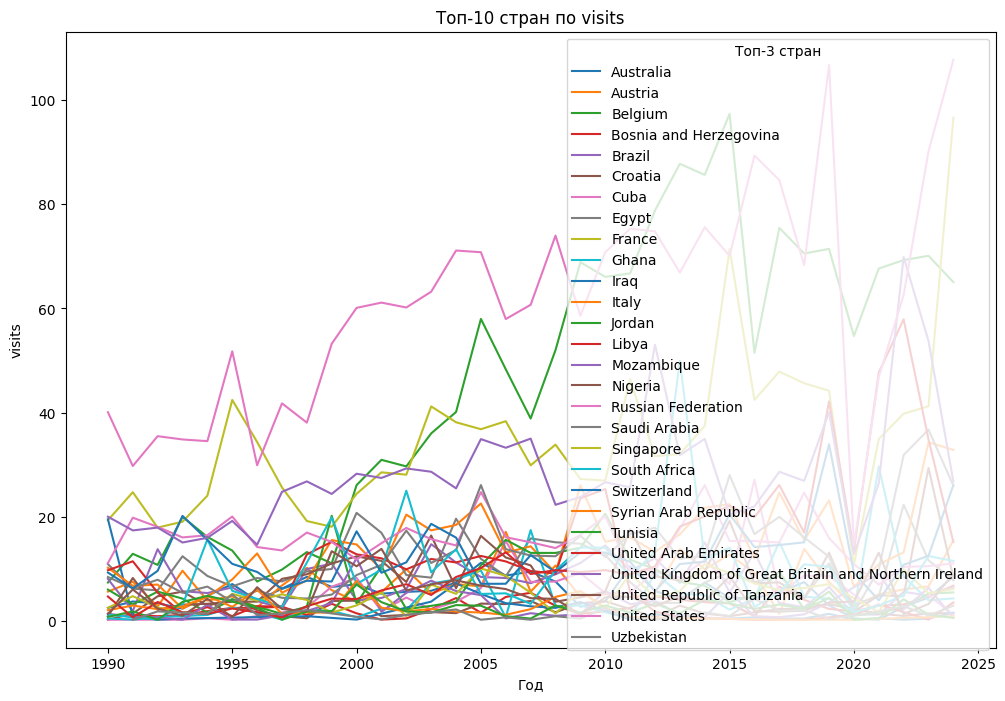

In [37]:
visits_df = visits.load_visits()
visits_df, visits_processed_df = visits.preprocess_visits(visits_df, year_start=YEAR_START, year_end=YEAR_END, rolling_window=5, normalize=True)
visits_df.to_csv("../data/basic_preprocessed/visits.csv")
visits_processed_df.to_csv("../data/preprocessed/visits.csv")

# Network Analysis

In [1280]:
def analyse_system(processed_dfs, year_start, year_end, centrality_type='pagerank'):
    # Analyzing centrality in the international system
    subsystems = {}
    centrality_data = []# sm_dyads.drop('alter', axis=1).drop_duplicates().set_index(['ego','year'])
    for subsystem in processed_dfs:
        logging.info(f"Analysing {subsystem}")
        df = processed_dfs[subsystem]
        
        df = df.reset_index()
        df['year'] = df['year'].astype(int)
        df = df.set_index(['year', 'alter', 'ego'], drop=True)
        countries_all = get_all_countries(processed_df=df.reset_index(), ego_column = 'ego', alter_column = 'alter')  # getting set of all countries
        networks = get_networks(df, countries_all, year_start=YEAR_START, year_end=YEAR_END)  # getting networks
        
        subsystems[subsystem] = {'data': df}#, 'networks':networks}
        for y in range(year_start, year_end+1):
            df_y = df.reset_index()
            df_y = df_y[df_y['year']==y]
            countries_all = set(df_y['ego']) or set(df_y['alter'])
            #countries_all = get_all_countries(processed_df=df_y.reset_index(), ego_column = 'ego', alter_column = 'alter')  # getting set of all countries
            #print(df)
            centrality = countCentrality(networks[y], country_list = countries_all, centrality_type=centrality_type, prefix='')
            #return centrality[0], centrality[1]
            centrality = centrality.sort_values(f'status')
            centrality['year'] = y
            centrality['subsystem'] = subsystem
            centrality_data += centrality,
    centrality_result = pd.concat(centrality_data)
    return centrality_result.reset_index().rename({'index':'ego'}, axis=1)


def get_central(df, name='test', year=2022):
    df = df.reset_index()
    df['year'] = df['year'].astype(int)
    df = df.set_index(['year', 'alter', 'ego'], drop=True)
    
    countries_all = get_all_countries(processed_df=df.reset_index(), ego_column = 'ego', alter_column = 'alter')  # getting set of all countries
    networks = get_networks(df, countries_all, year_start=YEAR_START, year_end=YEAR_END)  # getting netowrks
    
    security_centrality = countCentrality(networks[year], country_list = countries_all, centrality_type='out-degree-weighted', prefix=name).sort_values(f'{name}_status')
    
    return security_centrality, networks

def row_geometric_mean(row):
    """геометрическое среднее для N членов ряда row"""
    #print(row)
    values = row.values
    weights = list(SUBSYSTEM_WEIGHTS.values())
    return np.prod(values ** weights) ** (1 / np.sum(weights))

In [1281]:
# DATA ANSLYSIS
processed_dfs = {
    'security' : security_triple.fillna(0),
    'economy' : economy_triple.fillna(0),
    'human' : human_intermediate.fillna(0)
}
analysis = analyse_system(processed_dfs, year_start=YEAR_START, year_end=YEAR_END, centrality_type='out-degree-weighted')
#node, G = analyse_system(processed_dfs, year_start=YEAR_START, year_end=YEAR_END, centrality_type='out-degree-weighted')
#analysis['weighted_centrality'] = analysis.apply(lambda x: x['centrality'] * SUBSYSTEM_WEIGHTS[x['subsystem']], axis=1)

INFO:root:Analysing security
INFO:root:there are 196 unique countries, 196 - ego, 196 - alter
INFO:root:Getting global networks for 1985 - 2022
INFO:root:Done getting networks
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:root:analysing out-degree-weighted centrality
INFO:roo

In [1282]:
logging.info(f"Веса: {SUBSYSTEM_WEIGHTS}")
analysis_weighted = analysis.groupby(['ego', 'year']).centrality.agg(lambda x: row_geometric_mean(x))
analysis = analysis.set_index(['ego', 'year'])
analysis['weighted_centrality'] = analysis_weighted
analysis = analysis.reset_index()

INFO:root:Веса: {'security': 0.43301759133964823, 'economy': 0.32476319350473615, 'human': 0.2422192151556157}


In [1283]:
status_combined = analysis.groupby(['ego', 'year']).sum()
status_combined['weighted_centrality']=status_combined['weighted_centrality'].astype(int)
status_combined['rank_combined'] = status_combined['weighted_centrality'].groupby(['year']).rank(ascending=False, method='min')
analysis=analysis.reset_index(drop=True)

/tmp/ipykernel_361163/2759676704.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  status_combined = analysis.groupby(['ego', 'year']).sum()


In [1288]:
analysis.to_csv('../data/analysis.csv')
status_combined.to_csv('../data/status_combined.csv')

In [1289]:
analysis.to_excel('../output/analysis.xlsx')

# Визуализация

In [1188]:
RANKMIN=10  # Минимальный ранг в любой год, чтобы отражать страну в графике
MAXRANK=50  # Максимальный ранг, чтобы отражать ранг страны в конкретный год в графике
SPHERE='security'

def visualize_sphere(analysis, rankmin=RANKMIN, maxrank=MAXRANK, sphere=SPHERE):
    # Подготовка данных
    data = analysis[analysis['subsystem']==sphere]
    egos_top = data[data['rank']<=rankmin]['ego'].unique()
    data = data[data['ego'].isin(egos_top)]
    data = data[data['rank']<=maxrank]
    pivot_data = data.pivot_table(index='ego', columns='year', values='rank').sort_values(YEAR_END, ascending=True)
    plt.figure(figsize=(15, 6.5))
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', linewidths=1.8)
    plt.title(f'Тепловая карта по рангу стран ({sphere})')
    plt.text(0.5, -0.17,  
             f"*Примечание: пустые ячейки означают ранг >{maxrank} или отсутствие данных",
             ha='left', 
             va='center', 
             transform=plt.gca().transAxes,
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    plt.savefig(f'../output/{sphere}_ranks.png', dpi=300, bbox_inches='tight')
    plt.show()

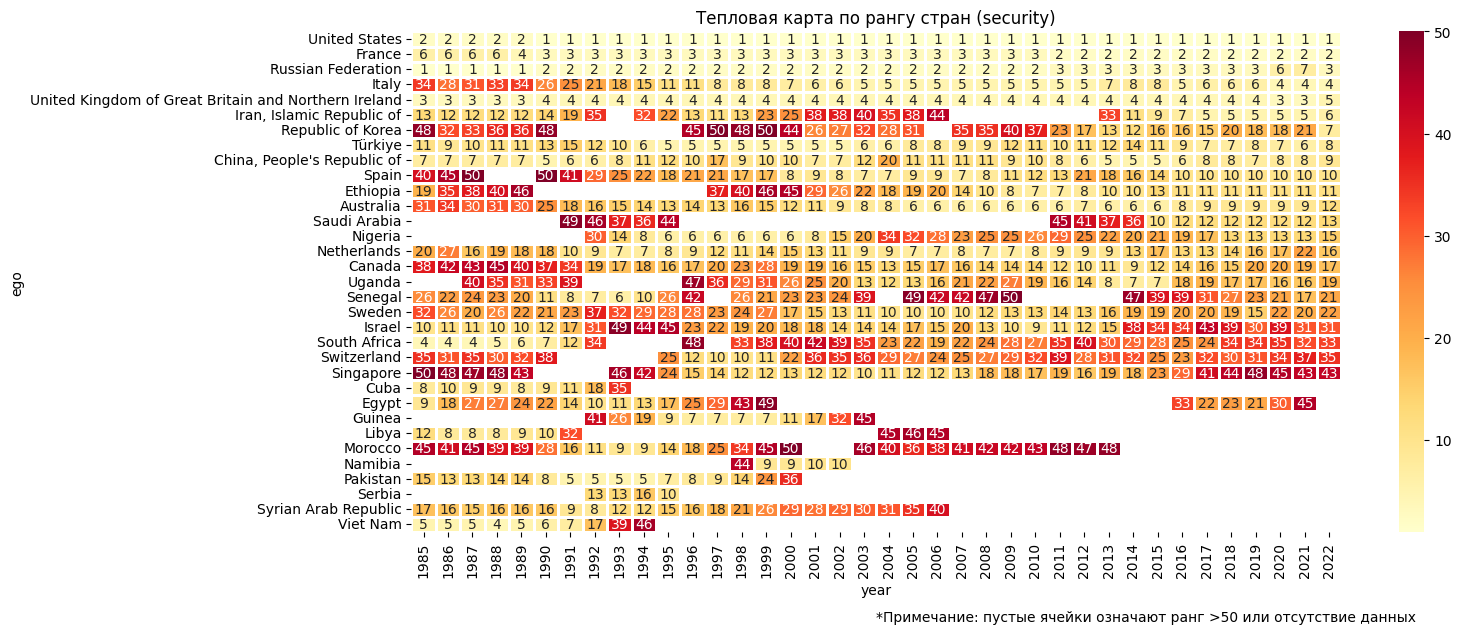

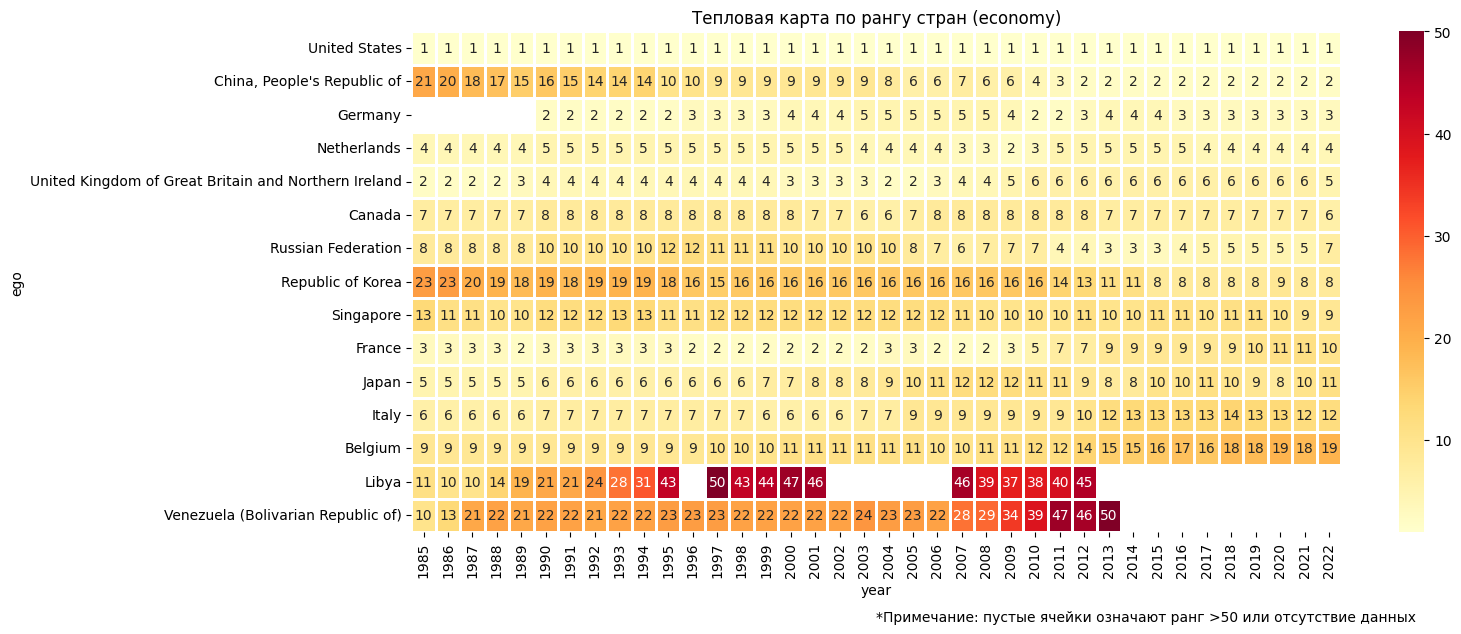

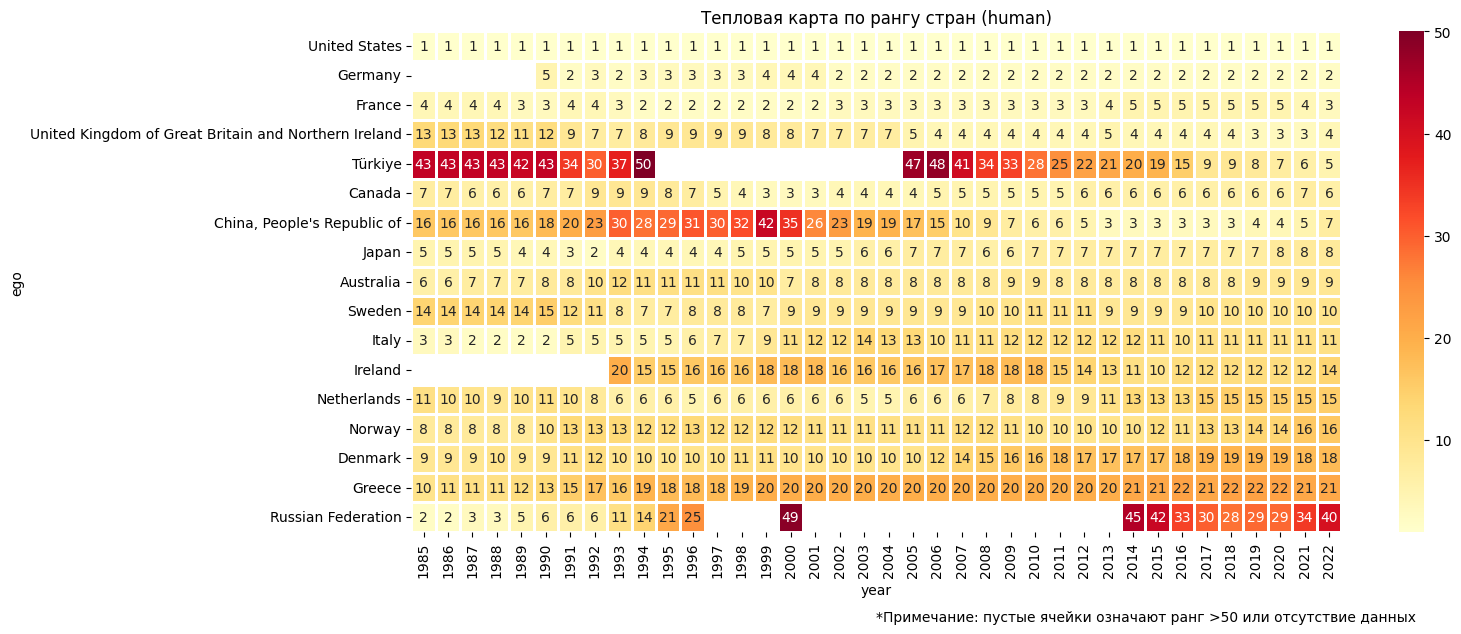

In [1287]:
visualize_sphere(analysis, sphere='security')
visualize_sphere(analysis, sphere='economy')
visualize_sphere(analysis, sphere='human')

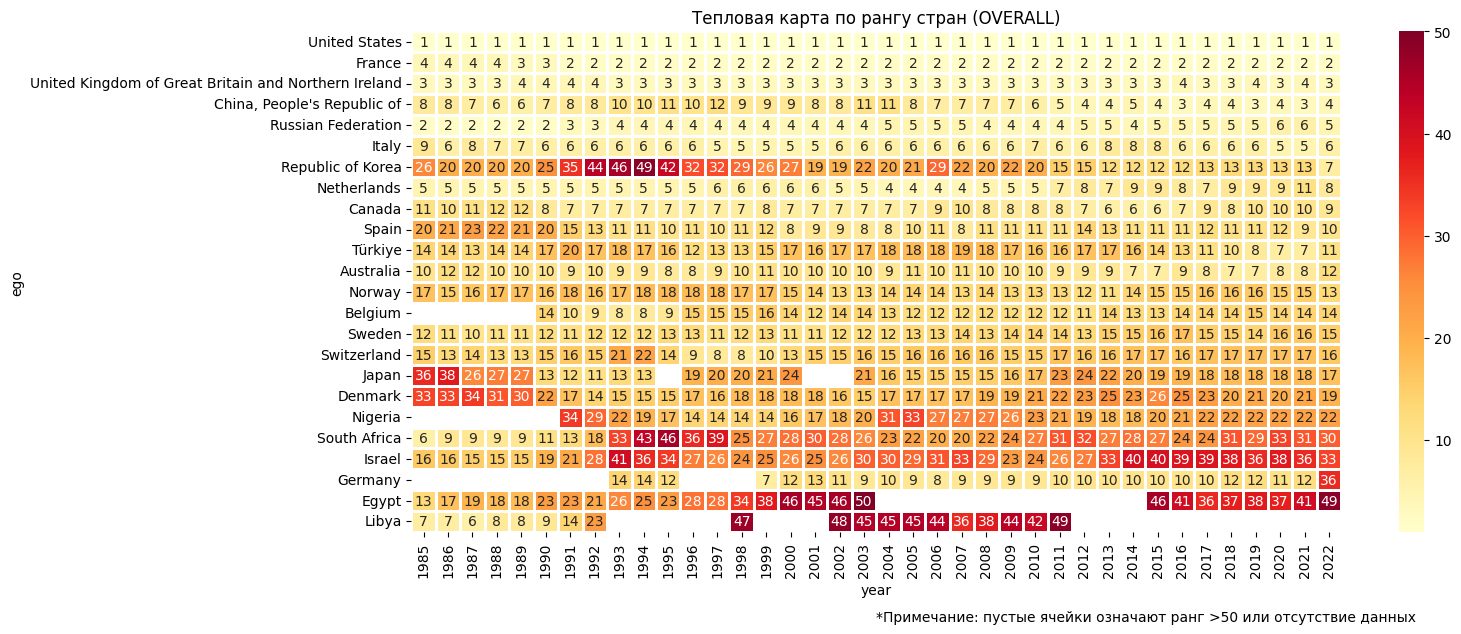

In [1286]:
#status_combined['rank_new']=(status_combined['rank'] / 3).sort_values()

RANKMIN=15
MAXRANK=50
SPHERE ='OVERALL'

data = status_combined.reset_index()
egos_top = data[data['rank_combined']<=RANKMIN]['ego'].unique()
data = data[data['ego'].isin(egos_top)]
data = data[data['rank_combined']<=MAXRANK]


pivot_data = data.pivot_table(index='ego', columns='year', values='rank_combined').sort_values(YEAR_END, ascending=True)
plt.figure(figsize=(15, 6.5))
sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', linewidths=1.8)
plt.title(f'Тепловая карта по рангу стран ({SPHERE})')
plt.xlim=(1992,2023)
plt.text(0.5, -0.17,  
         f"*Примечание: пустые ячейки означают ранг >{MAXRANK} или отсутствие данных",
         ha='left', 
         va='center', 
         transform=plt.gca().transAxes,
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.savefig(f'../output/{SPHERE}_ranks.png', dpi=300, bbox_inches='tight')
plt.show()